In [53]:
import pandas as pd
import numpy as np

import os
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

from sklearn.model_selection import train_test_split

import keras_metrics

import cv2

import torch 
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from time import sleep

from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

In [54]:
input_size = (32, 32)

def preprocess_dataset(image):
    image = cv2.resize(image, input_size)
    return image

In [55]:
# walk the directory containing alpaca/not alpaca and read them in. 
# might be different shapes
# all have 3 channels
alpaca_images = []
for dirname, _, filenames in os.walk('dataset/alpaca'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            pathname = os.path.join(dirname, filename)
            im = Image.open(pathname)
            imnp = np.array(im, dtype=float)
            if len(imnp.shape) != 3: # we'll ignore a few black-and-white (1 channel) images
                print("This is 1 channel, so we omit it", imnp.shape, filename)
                continue # do not add to our list
            imnp = preprocess_dataset(imnp)
            alpaca_images.append(imnp)

not_alpaca_images = []
for dirname, _, filenames in os.walk('dataset/not alpaca'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            pathname = os.path.join(dirname, filename)
            im = Image.open(pathname)
            imnp = np.array(im, dtype=float)
            if len(imnp.shape) != 3: # we'll ignore a few black-and-white (1 channel) images
                print("This is 1 channel, so we omit it", imnp.shape, filename)
                continue # do not add to our list
            imnp = preprocess_dataset(imnp)
            not_alpaca_images.append(imnp)

This is 1 channel, so we omit it (683, 1024) 4b9ef3ce2685ee32.jpg
This is 1 channel, so we omit it (914, 1024) 5a71db307230880e.jpg


In [56]:
print(f'''
alpaca: {len(alpaca_images)}
not alpaca: {len(not_alpaca_images)}''')


alpaca: 142
not alpaca: 183


The classes are fairly balanced

## Preprocessing data

In [57]:
# scale image from [0, 255] to [0, 1]
alpaca_images = np.asarray(alpaca_images) / 255.
not_alpaca_images = np.asarray(not_alpaca_images) / 255.

# loading data
X = np.concatenate((alpaca_images, not_alpaca_images), axis=0) # X.shape=(325, 300, 300, 3)

# 0 -> alpaca_images, 1-> not_alpaca_images
y = keras.utils.to_categorical(np.concatenate((np.zeros(alpaca_images.shape[0], dtype=int),  # y.shape=(325,)
                    np.ones(not_alpaca_images.shape[0], dtype=int)), 
                   axis=0))


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(262, 32, 32, 3) (262, 2)
(30, 32, 32, 3) (30, 2)
(33, 32, 32, 3) (33, 2)


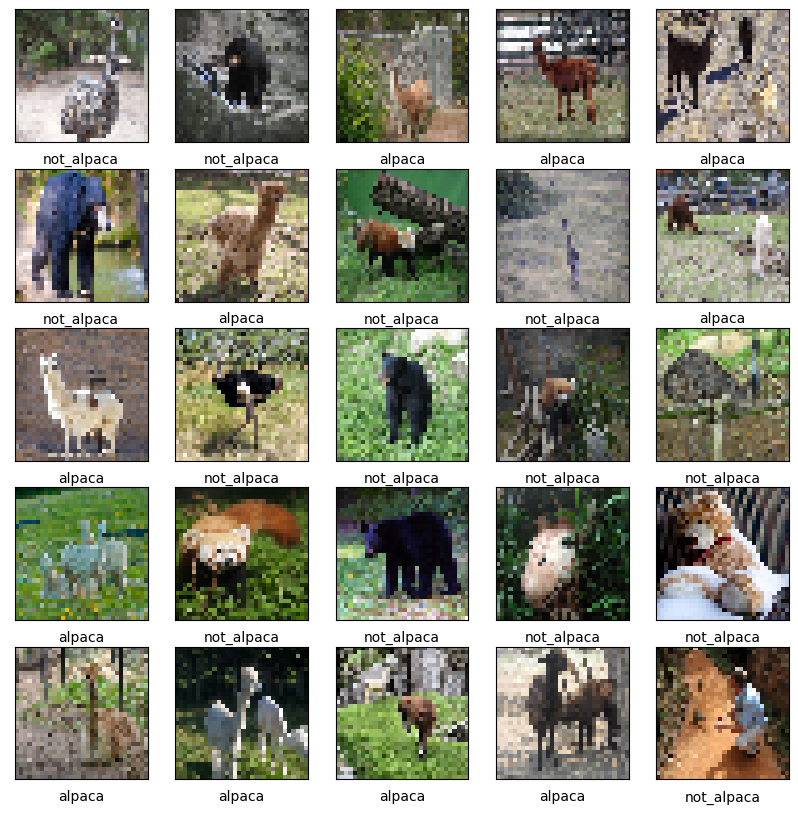

In [59]:
class_names = ['alpaca', 'not_alpaca']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[int(np.argmax(y_train[i]))])
plt.show()

## Traditional Conv2DModel Keras

In [60]:
cnn2d = keras.Sequential((
    # input layer
    keras.Input(shape=(32, 32, 3)),
    # convolutional layer1 + ActivationLayer1
    layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation='relu'),
    # PoolingLayer1
    layers.AveragePooling2D(pool_size=(2, 2)),
    
    # convolutional layer2 + ActivationLayer2
    layers.Conv2D(filters=12, kernel_size=(3, 3), strides=(1, 1), activation='relu'),
    # PoolingLayer2
    layers.AveragePooling2D(pool_size=(2, 2)),
    
    # convolutional layer3 + ActivationLayer33
    layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), activation='relu'),
    # Dense layer1
    layers.Flatten(name='flatten'),
    layers.Dense(12),
    
    # output layer
    layers.Dense(2, activation='softmax'),
))

In [61]:
cnn2d.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 16)        448       
                                                                 
 average_pooling2d_4 (Averag  (None, 15, 15, 16)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 12)        1740      
                                                                 
 average_pooling2d_5 (Averag  (None, 6, 6, 12)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 8)           872       
                                                                 
 flatten (Flatten)           (None, 128)              

### Train Conv2DModel Keras

In [62]:
cnn2d.compile(loss="categorical_crossentropy", 
              optimizer="sgd",
              metrics=[
                       #"accuracy", 
                       tf.keras.metrics.CategoricalAccuracy(),
                       tf.keras.metrics.Precision(thresholds=0.5),
                       tf.keras.metrics.Recall(thresholds=0.5)
                      ])


cnn2d.fit(X_train, y_train, batch_size=batch_size, epochs=EPOCHS, 
          validation_data = (X_val, y_val)
         )

cnn2d.save("models/keras_2dcnn.saved_model")

Epoch 1/5
 1/14 [=>............................] - ETA: 5s - loss: 0.7100 - categorical_accuracy: 0.4500 - precision_2: 0.4500 - recall_2: 0.4500

2023-03-25 21:29:35.329882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 50ms/step - loss: 0.6985 - categorical_accuracy: 0.4656 - precision_2: 0.4656 - recall_2: 0.4656 - val_loss: 0.7000 - val_categorical_accuracy: 0.4333 - val_precision_2: 0.4333 - val_recall_2: 0.4333
Epoch 2/5
 1/14 [=>............................] - ETA: 0s - loss: 0.6979 - categorical_accuracy: 0.4000 - precision_2: 0.4000 - recall_2: 0.4000

2023-03-25 21:29:35.988691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 16ms/step - loss: 0.6911 - categorical_accuracy: 0.5115 - precision_2: 0.5115 - recall_2: 0.5115 - val_loss: 0.6994 - val_categorical_accuracy: 0.4333 - val_precision_2: 0.4333 - val_recall_2: 0.4333
Epoch 3/5
14/14 [==============================] - 0s 14ms/step - loss: 0.6896 - categorical_accuracy: 0.5229 - precision_2: 0.5229 - recall_2: 0.5229 - val_loss: 0.7037 - val_categorical_accuracy: 0.5000 - val_precision_2: 0.5000 - val_recall_2: 0.5000
Epoch 4/5
14/14 [==============================] - 0s 14ms/step - loss: 0.6861 - categorical_accuracy: 0.5496 - precision_2: 0.5496 - recall_2: 0.5496 - val_loss: 0.7096 - val_categorical_accuracy: 0.5000 - val_precision_2: 0.5000 - val_recall_2: 0.5000
Epoch 5/5
14/14 [==============================] - 0s 15ms/step - loss: 0.6858 - categorical_accuracy: 0.5649 - precision_2: 0.5649 - recall_2: 0.5649 - val_loss: 0.7119 - val_categorical_accuracy: 0.5000 - val_precision_2: 0.5000 - val_recall_2: 0

INFO:tensorflow:Assets written to: models/keras_2dcnn.saved_model/assets


INFO:tensorflow:Assets written to: models/keras_2dcnn.saved_model/assets


### Evaluate Conv2DModel Keras

In [63]:
cnn2d.evaluate(
    x=X_test,
    y=y_test)

2/2 [==============================] - 0s 46ms/step - loss: 0.6717 - categorical_accuracy: 0.5758 - precision_2: 0.5758 - recall_2: 0.5758


[0.6716963052749634, 0.575757622718811, 0.575757622718811, 0.575757622718811]

# Pytorch

### Hyperparameters tuning

In [64]:
# learning rate:{0.1, 0.01, 0.001}, batch_size:{8, 16, 50}, epochs: {30, 40, 50}
            
lr = 0.001 #0.01 #0.1 
batch_size = 20
EPOCHS = 5
opt = 'Adam' # 'SGD'
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')


In [65]:
from torch.utils.data import TensorDataset, DataLoader

# Create data loaders for our datasets; shuffle for training, not for validation
train_set = TensorDataset(torch.tensor(X_train, dtype=torch.float),
                          torch.tensor(y_train, dtype=torch.float))
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True) 

val_set = TensorDataset(torch.tensor(X_val, dtype=torch.float),
                        torch.tensor(y_val, dtype=torch.float))
val_dataloader = DataLoader(val_set)

test_set = TensorDataset(torch.tensor(X_test, dtype=torch.float),
                         torch.tensor(y_test, dtype=torch.float))
test_dataloader = DataLoader(test_set)

# Traditional Conv2D approach Pytorch

In [66]:
class Conv2DModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.n_features_after_flatten = 128
        
        # Block 1
        self.proposedLayer1 = nn.Conv2d(3, 16, 3)
        self.relu1 = nn.ReLU() # activation layer 1
        self.pool1 = nn.AvgPool2d(2)
        
        # Block 2
        self.proposedLayer2 = nn.Conv2d(16, 12, 3)
        self.relu2 = nn.ReLU() # activation layer 1
        self.pool2 = nn.AvgPool2d(2)
        
        # Block 3
        self.proposedLayer3 = nn.Conv2d(12, 8, 3)
        self.relu3 = nn.ReLU() # activation layer 1
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(self.n_features_after_flatten, 12)
        self.dense = nn.Linear(12, 2)
        self.output = nn.Softmax(dim=1)

    def forward(self, x):
        ## torch expected input format = (N, C, H, W)
        ## torch output format follows the same
        
        # Block 1
        x = self.proposedLayer1(x) ##(N, H, W, C)
        x = self.relu1(x)
        x = self.pool1(x)
        
#         # Block 2
        x = self.proposedLayer2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
#         # Block 3
        x = self.proposedLayer3(x)
        x = self.relu3(x)
        x = self.flatten(x).to(torch.float32)
        x = self.fc(x).float()
        x = self.dense(x)
        x = self.output(x)
        
        return x

### Train Conv2D Model

In [67]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    running_acc = 0
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    dataloader_tqdm = tqdm(train_dataloader)
    for i, data in enumerate(dataloader_tqdm):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = conv2d_model(torch.permute(inputs, (0, 3, 1, 2)))#.squeeze(1)

        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item() * inputs.size(0)
        running_acc += torch.sum(outputs.argmax(dim=1) == labels.argmax(dim=1))
        
        dataloader_tqdm.set_postfix_str('  sample {} loss: {} accuracy: {}'.format(
            i + 1, running_loss, running_acc))
        sleep(0.01)
    
    last_loss = running_loss / len(X_train)
    last_acc = running_acc.double() / len(X_train)
 
    tb_x = epoch_index * len(train_dataloader) + i + 1
    tb_writer.add_scalar('Loss/train', last_loss, tb_x)

    return last_loss, last_acc

In [68]:
# Initializing in a separate cell so we can easily add more epochs to the same run
writer = SummaryWriter('runs/conv2d_{}_{}_{}_{}_{}'.format(timestamp, lr, batch_size, EPOCHS, opt))
epoch_number = 0
criterion = nn.CrossEntropyLoss()

conv2d_model = Conv2DModel().float()
if opt == 'SGD':
    optimizer = optim.SGD(conv2d_model.parameters(), lr=lr)
elif opt == 'Adam':
    optimizer = optim.Adam(conv2d_model.parameters(), lr=lr)
    
best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print(('EPOCH {}:'.format(epoch_number + 1)))

    # Make sure gradient tracking is on, and do a pass over the data
    conv2d_model.train(True)
    avg_loss, avg_acc = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    conv2d_model.train(False)

    running_vloss = 0.0
    running_vacc = 0
    for i, vdata in enumerate(val_dataloader):
        vinputs, vlabels = vdata
        voutputs = conv2d_model(torch.permute(vinputs, (0, 3, 1, 2)))#.squeeze(1)
        running_vacc += torch.sum(voutputs.argmax(dim=1) == vlabels.argmax(dim=1))
        vloss = criterion(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    avg_vacc = running_vacc / (i + 1)
    print('LOSS train {} valid {}; ACC train {} valid {}'.format(
        avg_loss, avg_vloss, avg_acc, avg_vacc))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.add_scalars('Training vs. Validation Accuracy',
                    { 'Training' : avg_acc, 'Validation' : avg_vacc },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'models/conv2dmodel_{}_{}_{}_{}_{}_{}'.format(
            epoch_number,timestamp, lr, batch_size, EPOCHS, opt)
        torch.save(conv2d_model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 53.04it/s,   sample 14 loss: 180.5470768213272 accuracy: 148]


LOSS train 0.6891109802340734 valid 0.6935106515884399; ACC train 0.5648854961832062 valid 0.5
EPOCH 2:


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 52.45it/s,   sample 14 loss: 179.91340017318726 accuracy: 148]


LOSS train 0.6866923670732338 valid 0.6937432885169983; ACC train 0.5648854961832062 valid 0.5
EPOCH 3:


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 53.03it/s,   sample 14 loss: 179.26230764389038 accuracy: 148]


LOSS train 0.6842072810835511 valid 0.6969982385635376; ACC train 0.5648854961832062 valid 0.5
EPOCH 4:


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 52.69it/s,   sample 14 loss: 179.31244206428528 accuracy: 148]


LOSS train 0.6843986338331499 valid 0.6953752636909485; ACC train 0.5648854961832062 valid 0.5
EPOCH 5:


100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 53.16it/s,   sample 14 loss: 177.9499592781067 accuracy: 148]


LOSS train 0.679198317855369 valid 0.6967166662216187; ACC train 0.5648854961832062 valid 0.5


## Evaluation

In [69]:
y_pred = []
y_true = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = conv2d_model(torch.permute(images, (0, 3, 1, 2)))
        y_pred.append(outputs.argmax(dim=1).numpy())
        y_true.append(labels.argmax(dim=1).numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

report = classification_report(y_true, y_pred, target_names=class_names,
                         output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("evaluation/conv2d_{}_{}_{}_{}_{}.csv".format(
    timestamp, lr, batch_size, EPOCHS, opt), index=False)

              precision    recall  f1-score   support

      alpaca       0.00      0.00      0.00        13
  not_alpaca       0.61      1.00      0.75        20

    accuracy                           0.61        33
   macro avg       0.30      0.50      0.38        33
weighted avg       0.37      0.61      0.46        33



# Proposed Layer

In [70]:
class ProposedLayer(nn.Module):    
    def __init__(self, X, num_filters, rf=3, stride=1):
        super().__init__()
        
        self.height = len([1] * X[0])
        self.width = len([1] * X[1])
        self.channel = len([1] * X[2]) 
        
        self.rf = rf
        self.num_filters = num_filters
        self.stride = stride
        self.featureMaps = []
        for n in range(self.num_filters):
            self.weightMatrix = torch.tensor(np.random.rand(self.height, self.width, self.channel))
            self.featureMaps.append(self.weightMatrix)
        self.featureMaps = torch.stack(self.featureMaps, dim=0)
        self.featureMaps = Variable(self.featureMaps, requires_grad=True)
        
    def __len__(self, x):
        return len(x)
      
    def forward(self, X):
        self.batch = len(X[:,0])

        output = torch.tensor(np.empty((self.batch, self.height-self.rf+1, self.width-self.rf+1, self.num_filters)))
                
        for row in range(self.height - self.rf + 1):
            for col in range(self.width - self.rf + 1):
                for j,_ in enumerate(self.featureMaps):
                    for i,_ in enumerate(X):
                        
                        receptive_field = self.featureMaps[j, row: row+self.rf, col: col+self.rf, :]
                        x_field = X[i, row: row+self.rf, col: col+self.rf, :]                        
                        x_field_ = torch.flatten(x_field)
                        receptive_field_ = torch.flatten(receptive_field)
                        output[i, row, col] = np.dot(x_field_, receptive_field_.detach())                                
        
        return torch.permute(output, (0, 3, 1, 2))

### Proposed Model

In [71]:
class ProposedModel(nn.Module):
    def __init__(self):
        super().__init__()        
        self.n_features_after_flatten = 128
        
        # Block 1
        self.proposedLayer1 = ProposedLayer((32, 32, 3), num_filters=16, rf=3, stride=1) # proposed layer 1
        self.relu1 = nn.ReLU() # activation layer 1
        self.pool1 = nn.AvgPool2d(2)
        
        # Block 2
        self.proposedLayer2 = ProposedLayer((15, 15, 16), num_filters=12, rf=3, stride=1) # proposed layer 1
        self.relu2 = nn.ReLU() # activation layer 1
        self.pool2 = nn.AvgPool2d(2)
        
        # Block 3
        self.proposedLayer3 = ProposedLayer((6,  6, 12), num_filters=8, rf=3, stride=1) # proposed layer 1
        self.relu3 = nn.ReLU() # activation layer 1
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(self.n_features_after_flatten, 12)
        self.dense = nn.Linear(12, 2)
        self.output = nn.Softmax(dim=1)

    def forward(self, x):
        ## torch expected input format = (N, C, H, W)
        ## torch output format follows the same
        
        # Block 1
        x = self.proposedLayer1(x) ##(N, H, W, C)
        x = self.relu1(x)
        x = self.pool1(x)
        x = torch.permute(x, (0, 2, 3, 1)) ##(N, H, W, C)
        
        # Block 2
        x = self.proposedLayer2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = torch.permute(x, (0, 2, 3, 1))
        
        # Block 3
        x = self.proposedLayer3(x)
        x = self.relu3(x)
        x = self.flatten(x).to(torch.float32)
        x = self.fc(x).float()
        x = self.dense(x)
        x = self.output(x)
        
        return x

## Train Proposed Model

In [72]:
def train_one_epoch_pm(epoch_index, tb_writer):
    running_loss = 0.
    running_acc = 0
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    dataloader_tqdm = tqdm(train_dataloader)
    for i, data in enumerate(dataloader_tqdm):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = pm_model(inputs)#.squeeze(1)

        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item() * inputs.size(0)
        running_acc += torch.sum(outputs.argmax(dim=1) == labels.argmax(dim=1))
        dataloader_tqdm.set_postfix_str('  sample {} loss: {} accuracy: {}'.format(
            i + 1, running_loss, running_acc))
        sleep(0.01)
    
    last_loss = running_loss / len(X_train)
    last_acc = running_acc.double() / len(X_train)
    
    tb_x = epoch_index * len(train_dataloader) + i + 1
    tb_writer.add_scalar('Loss/train', last_loss, tb_x)

    return last_loss, last_acc

In [73]:
# Initializing in a separate cell so we can easily add more epochs to the same run
writer = SummaryWriter('runs/pm_{}_{}_{}_{}_{}'.format(timestamp, lr, batch_size, EPOCHS, opt))
epoch_number = 0
criterion = nn.CrossEntropyLoss()

pm_model = ProposedModel().float()
if opt == 'SGD':
    optimizer = optim.SGD(pm_model.parameters(), lr=lr)
elif opt == 'Adam':
    optimizer = optim.Adam(pm_model.parameters(), lr=lr)

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print(('EPOCH {}:'.format(epoch_number + 1)))

    # Make sure gradient tracking is on, and do a pass over the data
    pm_model.train(True)
    avg_loss, avg_acc = train_one_epoch_pm(epoch_number, writer)

    # We don't need gradients on to do reporting
    pm_model.train(False)

    running_vloss = 0.0
    running_vacc = 0
    for i, vdata in enumerate(val_dataloader):
        vinputs, vlabels = vdata
        voutputs = pm_model(vinputs)#.squeeze(1)
        running_vacc += torch.sum(voutputs.argmax(dim=1) == vlabels.argmax(dim=1))
        vloss = criterion(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    avg_vacc = running_vacc / (i + 1)
    print('LOSS train {} valid {}; ACC train {} valid {}'.format(
        avg_loss, avg_vloss, avg_acc, avg_vacc))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.add_scalars('Training vs. Validation Accuracy',
                    { 'Training' : avg_acc, 'Validation' : avg_vacc },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'models/proposedmodel_{}_{}_{}_{}_{}_{}'.format(
            epoch_number,timestamp, lr, batch_size, EPOCHS, opt)
        torch.save(pm_model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


100%|██████████████████████████████████████████| 14/14 [01:31<00:00,  6.51s/it,   sample 14 loss: 196.0745535492897 accuracy: 148]


LOSS train 0.7483761585850752 valid 0.8132615685462952; ACC train 0.5648854961832062 valid 0.5
EPOCH 2:


100%|█████████████████████████████████████████| 14/14 [01:30<00:00,  6.43s/it,   sample 14 loss: 196.07455325126648 accuracy: 148]


LOSS train 0.748376157447582 valid 0.8132615685462952; ACC train 0.5648854961832062 valid 0.5
EPOCH 3:


100%|█████████████████████████████████████████| 14/14 [01:29<00:00,  6.38s/it,   sample 14 loss: 196.07455682754517 accuracy: 148]


LOSS train 0.7483761710975007 valid 0.8132615685462952; ACC train 0.5648854961832062 valid 0.5
EPOCH 4:


100%|██████████████████████████████████████████| 14/14 [01:30<00:00,  6.46s/it,   sample 14 loss: 196.0745559334755 accuracy: 148]


LOSS train 0.748376167685021 valid 0.8132615685462952; ACC train 0.5648854961832062 valid 0.5
EPOCH 5:


100%|█████████████████████████████████████████| 14/14 [01:29<00:00,  6.40s/it,   sample 14 loss: 196.07455444335938 accuracy: 148]


LOSS train 0.7483761619975549 valid 0.8132615685462952; ACC train 0.5648854961832062 valid 0.5


## Evaluation

In [74]:
# since we're not training, we don't need to calculate the gradients for our outputs
y_pred = []
y_true = []
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = pm_model(images)
        y_pred.append(outputs.argmax(dim=1).numpy())
        y_true.append(labels.argmax(dim=1).numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

report = classification_report(y_true, y_pred, target_names=class_names,
                         output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("evaluation/pm_{}_{}_{}_{}_{}.csv".format(
    timestamp, lr, batch_size, EPOCHS, opt), index=False)

              precision    recall  f1-score   support

      alpaca       0.00      0.00      0.00        13
  not_alpaca       0.61      1.00      0.75        20

    accuracy                           0.61        33
   macro avg       0.30      0.50      0.38        33
weighted avg       0.37      0.61      0.46        33



In [75]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


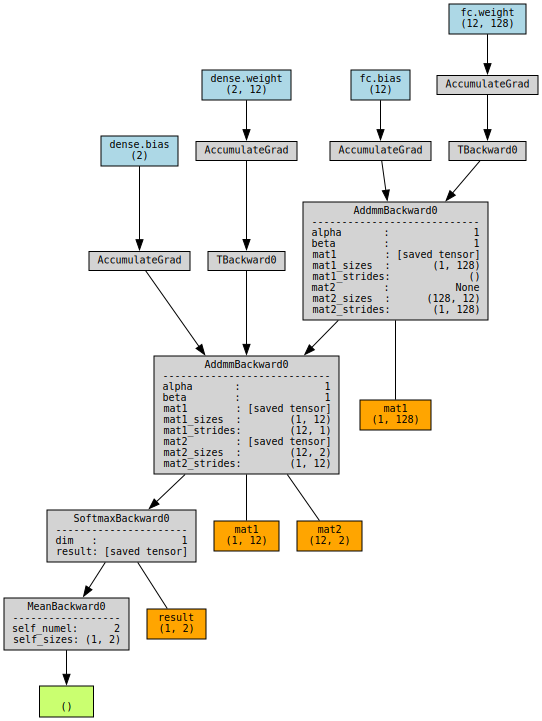

In [76]:
x = torch.tensor(X_train, dtype=torch.float)

from torchviz import make_dot

model = ProposedModel().float()
y = model(x[:1])
make_dot(y.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)


In [77]:
%tensorboard --logdir runs


Reusing TensorBoard on port 6006 (pid 10754), started 0:24:06 ago. (Use '!kill 10754' to kill it.)